### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
import numpy as np
import json
import operator
from typing import Annotated, List, Tuple, TypedDict, Optional, Any
from IPython.display import Image, display

from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END

import constants, utils, prompts
from epub_parser import EPUB, ContentNode, Metadata
from data_classes.chapter_summary import ChapterSummary
from data_classes.book_summarizer_state import BookSummarizerState
from data_classes.book_summarizer_state_summarizer_agent import BookSummarizerStateSummarizerAgent
from llm_agents.relevant_chapter_selector import AgentRelevantChaptersSelector
from llm_agents.section_summarizer import AgentSectionSummarizer
from llm_agents.summaries_aggregator import AgentSummariesAggregator
from non_llm_agents.epub_loader import AgentEpubLoader
from non_llm_agents.chapters_loader import AgentChaptersLoader
from non_llm_agents.results_reporter import AgentResultsReporter
from non_llm_agents.chapter_router import AgentChapterRouter

os.environ["OPENAI_API_KEY"] = utils.get_openai_api_key()
os.environ["TAVILY_API_KEY"] = utils.get_tavily_api_key()

### Create the Graph

In [2]:
graph = StateGraph(BookSummarizerState)

graph.add_node("Epub Loader", AgentEpubLoader())
graph.add_node("Relevant Chapters Selector", AgentRelevantChaptersSelector())
graph.add_node("Chapters Loader", AgentChaptersLoader())
graph.add_node("Section Summarizer", AgentSectionSummarizer())
graph.add_node("Summaries Aggregator", AgentSummariesAggregator())
graph.add_node("Results Reporter", AgentResultsReporter())

graph.set_entry_point("Epub Loader")
graph.add_edge("Epub Loader", "Relevant Chapters Selector")
graph.add_edge("Relevant Chapters Selector", "Chapters Loader")
graph.add_conditional_edges("Chapters Loader", AgentChapterRouter(), ["Section Summarizer"])
graph.add_edge("Section Summarizer", "Summaries Aggregator")
graph.add_edge("Summaries Aggregator", "Results Reporter")
graph.add_edge("Results Reporter", END)

app = graph.compile()

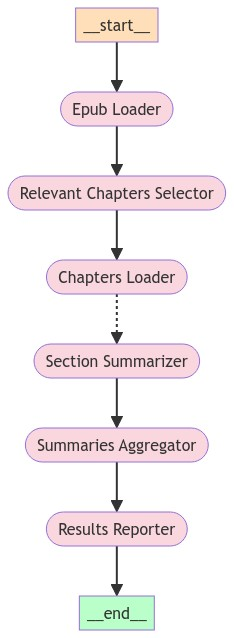

In [3]:
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

### Execute the Graph


In [4]:
config = {"recursion_limit": 50}
# book_name = "Eat that Frog!"
book_name = "eat_that_frog"
# book_dir = constants.BOOKS_DIR + 'eat_that_frog.epub'
book_dir = constants.BOOKS_DIR + "eat_that_frog.epub"
num_chapters_to_summarize = 2
verbose = 0
inputs = {"book_name": book_name, "book_dir": book_dir, "num_chapters_to_summarize": num_chapters_to_summarize, "verbose": verbose}
# inputs = (book_name=book_name, book_dir= book_dir, num_chapters_to_summarize= num_chapters_to_summarize, verbose= verbose)
book_config = BookSummarizerState(**inputs)

for event in app.stream(book_config.dict(), config=config):
    print("Event:", event)


/home/pedro/Documents/Virtual-Environments/ai/lib/python3.10/site-packages/ebooklib/epub.py:1395: UserWarning: In the future version we will turn default option ignore_ncx to True.
  warnings.warn('In the future version we will turn default option ignore_ncx to True.')
/home/pedro/Documents/Virtual-Environments/ai/lib/python3.10/site-packages/ebooklib/epub.py:1423: FutureWarning: This search incorrectly ignores the root element, and will be fixed in a future version.  If you rely on the current behaviour, change it to './/xmlns:rootfile[@media-type]'
  for root_file in tree.findall('//xmlns:rootfile[@media-type]', namespaces={'xmlns': NAMESPACES['CONTAINERNS']}):




 33 chapters found in the book
Event: {'Epub Loader': {'book_name': 'eat_that_frog', 'verbose': 0, 'book_dir': '/home/pedro/Documents/GitHub/SwarmGPT/data/books/eat_that_frog.epub', 'book': <epub_parser.EPUB object at 0x7f14127708b0>, 'chapter_titles_all': ['Cover Page', 'Title Page', 'Copyright Page', 'Dedication', 'Contents', 'Preface', 'Introduction: Eat That Frog', '1 Set the Table', '2 Plan Every Day in Advance', '3 Apply the 80/20 Rule to Everything', '4 Consider the Consequences', '5 Practice Creative Procrastination', '6 Use the ABCDE Method Continually', '7 Focus on Key Result Areas', '8 Apply the Law of Three', '9 Prepare Thoroughly Before You Begin', '10 Take It One Oil Barrel at a Time', '11 Upgrade Your Key Skills', '12 Identify Your Key Constraints', '13 Put the Pressure on Yourself', '14 Motivate Yourself into Action', '15 Technology Is a Terrible Master', '16 Technology Is a Wonderful Servant', '17 Focus Your Attention', '18 Slice and Dice the Task', '19 Create Large 